In [2]:
import dynamiqs as dq
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.integrate import simpson
from scipy.ndimage import gaussian_filter
from wigner_from_data import wigner_from_data

# Task A

## Utility Functions

In [21]:
#utility functions for affine distortions
#affinely distort wigner function
def affine_distort(wigner, alpha, b):
    return alpha*wigner+b

#add gaussian noise to wigner function
def add_gaussian_noise(wigner, sigma):
    noise = sigma*jax.random.normal(jax.random.key(0), wigner.shape)
    return jnp.add(wigner, noise)

def add_affine_gaussian_noise(wigner, alpha, b, sigma):
    #add afine first
    affine_wigner = affine_distort(wigner, alpha, b)
    #add gaussian noise
    return add_gaussian_noise(affine_wigner, sigma)

#calculate the norm of a wigner function
def integrate_wigner(wigner, x, y):
    return simpson(simpson(wigner, y), x)

#calculate the b value of the affine distortion
def recover_affine_offset(wigner):
    x_len, y_len = wigner.shape
    #assuming the corners don't make too much of a difference
    return 0.25*(jnp.mean(wigner[0,:]) + jnp.mean(wigner[x_len-1,:]) + jnp.mean(wigner[:,0]) + jnp.mean(wigner[:,y_len-1]))

#calculate the alpha value of the affine distortion
def recover_affine_scaling(zeroed_wigner, x, y):
    return integrate_wigner(zeroed_wigner, x, y)

#remove the affine distortion of a wigner function
def remove_affine_distortion(affine_wigner, x, y):
    b = recover_affine_offset(affine_wigner)
    zeroed_affine_wigner = affine_wigner - b
    alpha = recover_affine_scaling(zeroed_affine_wigner, x, y)
    return zeroed_affine_wigner/alpha

#run the simple affine denoising + gaussian filter pipeline
def remove_affine_gaussian_noise(noisy_wigner, x, y, sigma):
    #remove affine noise
    affine_less_wigner = remove_affine_distortion(noisy_wigner, x, y)
    #apply gaussian filter
    filtered_wigner = gaussian_filter(affine_less_wigner, sigma)
    return filtered_wigner

## Benchmarking

In [97]:
def benchmark_fidelity(reference_state, alpha, b, noise_sigma, filter_sigma):
    #setup the references/truths
    reference_dm = dq.todm(reference_state)
    x, y, reference_wigner = dq.wigner(reference_state, npixels=15, xmax=2, ymax=2)

    #add noise to the wigner function
    noisy_wigner = add_affine_gaussian_noise(reference_wigner, alpha, b, noise_sigma)
    #reconstruct from noisy data
    noisy_dm = wigner_from_data(noisy_wigner, x, y, 5)
    noisy_fidelity = dq.fidelity(reference_state, noisy_dm)

    #reconstruct from denoised data
    denoised_wigner = remove_affine_gaussian_noise(noisy_wigner, x, y, filter_sigma)
    denoised_dm = wigner_from_data(denoised_wigner, x, y, 5)
    denoised_fidelity = dq.fidelity(reference_state, denoised_dm)
    
    return noisy_fidelity, denoised_fidelity

In [98]:
reference = dq.fock(5, 1)
v_alpha = np.linspace(0.1, 2.1, 7)
alpha_zero_zero_zero = []
for alpha in v_alpha:
    temp_fidelity = benchmark_fidelity(reference, alpha, 0, 0, 0)
    alpha_zero_zero_zero.append(temp_fidelity)

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 11 04:27:17 AM: Your problem has 25 variables, 26 constraints, and 0 parameters.
(CVXPY) May 11 04:27:17 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 11 04:27:17 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 11 04:27:17 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 11 04:27:17 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 11 04:27:17 AM: Compiling problem (target solver=MOSEK).
(C

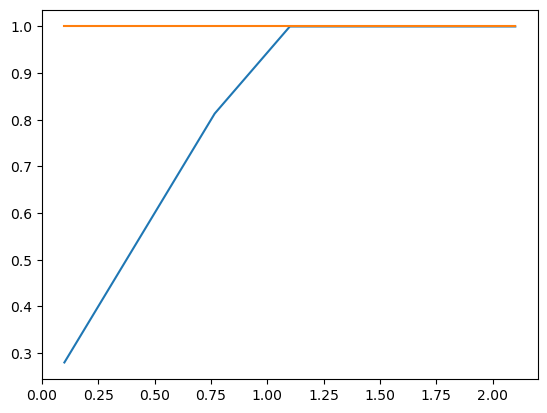

In [99]:
plt.plot(v_alpha, alpha_zero_zero_zero)

In [100]:
reference = dq.fock(5, 1)
v_b = np.linspace(0.1, 2.1, 7)
one_b_zero_zero = []
for b in v_b:
    temp_fidelity = benchmark_fidelity(reference, 1, b, 0, 0)
    one_b_zero_zero.append(temp_fidelity)

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 11 04:27:34 AM: Your problem has 25 variables, 26 constraints, and 0 parameters.
(CVXPY) May 11 04:27:34 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 11 04:27:34 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 11 04:27:34 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 11 04:27:34 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 11 04:27:34 AM: Compiling problem (target solver=MOSEK).
(C

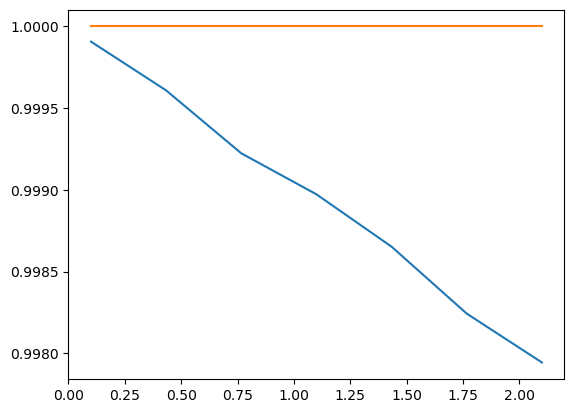

In [101]:
plt.plot(v_b, one_b_zero_zero)

In [102]:
reference = dq.fock(5, 1)
v_noise = np.linspace(0, 2, 21)
one_zero_noise_zero = []
for noise in v_noise:
    temp_fidelity = benchmark_fidelity(reference, 1, 0, noise, 0)
    one_zero_noise_zero.append(temp_fidelity)

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 11 04:27:49 AM: Your problem has 25 variables, 26 constraints, and 0 parameters.
(CVXPY) May 11 04:27:49 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 11 04:27:49 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 11 04:27:49 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 11 04:27:49 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 11 04:27:49 AM: Compiling problem (target solver=MOSEK).
(C

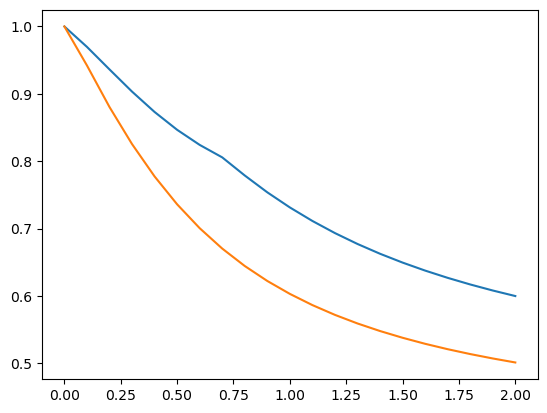

In [103]:
plt.plot(v_noise, one_zero_noise_zero)

In [107]:
reference = dq.coherent(5, 3)
v_filter = np.linspace(0, 2, 21)
one_zero_025_filter = []
for filter in v_filter:
    temp_fidelity = benchmark_fidelity(reference, 1, 0, 0.25, filter)
    one_zero_025_filter.append(temp_fidelity)

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 11 04:30:14 AM: Your problem has 25 variables, 26 constraints, and 0 parameters.
(CVXPY) May 11 04:30:14 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 11 04:30:14 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 11 04:30:14 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 11 04:30:14 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 11 04:30:14 AM: Compiling problem (target solver=MOSEK).
(C

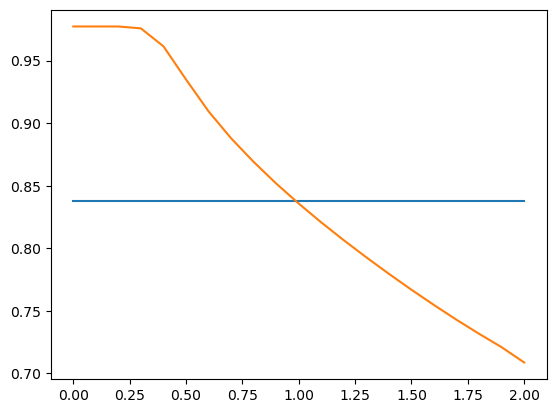

In [108]:
plt.plot(v_filter, one_zero_025_filter)